# Setting up the environment

To set up a conda environment with everything you need to run this notebook, go to the directory with the notebook in a shell on your computer and run the command:
```
mamba env create -n py310_aisem2023 -f environment.yml
```
If you don't have mamba installed, either start with:
```
conda install -c conda-forge mamba
```
and then run the `mamba env` command above or do:
```
conda env create -n py310_aisem2023 -f environment.yml
```
(but this last alternative will be considerably slower)


# Ok, let's start

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
import rdkit
print(rdkit.__version__)

2022.09.5


In [3]:
import pandas as pd
print(pd.__version__)
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('tableau-colorblind10')

2.0.0


# Preparing a dataset to learn

Start easy with one of the data sets from yesterday. carbonic anhydrase. Real dataset from CHEMBL (pre-cleaned)

,compound_chembl_id,canonical_smiles,pchembl_value,standard_value,standard_units,standard_relation,standard_type,ROMol
0,CHEMBL1054,NS(=O)(=O)c1cc2c(cc1Cl)NC(C(Cl)Cl)NS2(=O)=O,7.04,91.0,nM,=,Ki,
1,CHEMBL1055,NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl,6.86,138.0,nM,=,Ki,
2,CHEMBL106848,NS(=O)(=O)c1ccc(SCCO)cc1,7.68,21.0,nM,=,Ki,
3,CHEMBL107217,CCN(CC)C(=S)[S-].[Na+],5.51,3100.0,nM,=,Ki,
4,CHEMBL1081233,CCCCC(CC)C(N)=O,5.46,3450.0,nM,=,Ki,

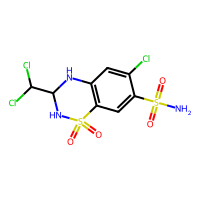
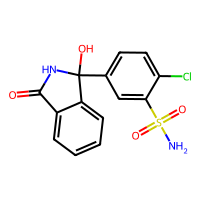
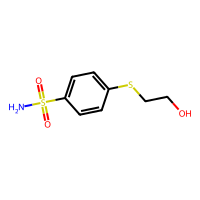
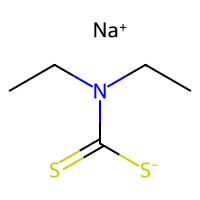
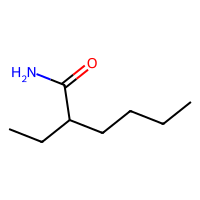

In [5]:
df = pd.read_csv('../Chemical_Data_Science/data/Ki_data/target_CHEMBL205.csv.gz')
PandasTools.AddMoleculeColumnToFrame(df,'canonical_smiles')
PandasTools.RenderImagesInAllDataFrames(True)
df.head()

Start by standardizing the molecules:

In [6]:
# The standardizer is very verbose... turn that off:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')
# and now standardize the molecules:
from rdkit.Chem.MolStandardize import rdMolStandardize
df['mol_parent'] = df.ROMol.map(rdMolStandardize.ChargeParent)


Now generate fingerprints

In [8]:
from rdkit.Chem import rdFingerprintGenerator

# Greg default is morgan fp, radius 2 as starting pt. 
# if solubility, would use descriptors. see later
# note: chirality off by default bc public db not well QC-ed with chembl
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
# note: GetFingerprintAsNumPy is faster than GetFingerprint
fps = [fpg.GetFingerprintAsNumPy(m) for m in df.mol_parent]

We're going to build a classification - i.e. active/inactive - model, so convert the pchembl_values to 1s and 0s by binning activity at 7 (corresponds Ki = 100 nM). For categorical, could add additional bins.

In [9]:
acts = [1 if x>=7 else 0 for x in df.pchembl_value]

In [7]:
len(acts),sum(acts)

(4511, 2662)

Is uncommmonly balanced actives/inactives! 

Now we need a training/test split. Scikit learn has tools for that:

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fps,
                                                    acts,
                                                    test_size=0.2,
                                                    random_state=0xf00d,
                                                    shuffle=True,
                                                    stratify=acts)
# note stratify according to actives/inactives 

In [14]:
len(y_train),sum(y_train)

(3608, 2129)

Build a random forest with that. I have a standard set of hyperparameters that I use for this:

In [16]:
from sklearn.ensemble import RandomForestClassifier

# n_estimators can be 100 or 200, choose smallest n at plateau of performance
# max_depth can by optimized (hyper parameter), avoids overfitting of too deep uncommunicable trees
# n_jobs, more comp intensive if higher
cls = RandomForestClassifier(n_estimators=500,
                             max_depth=15,
                             oob_score=True,
                             random_state=0xf00d,
                             n_jobs=4)
cls.fit(X_train,y_train)

RandomForestClassifier(max_depth=15, n_estimators=500, n_jobs=4, oob_score=True,
                       random_state=61453)

Look at how we did.

Start with accuracy on the training set:

In [17]:
from sklearn import metrics
from scipy import stats

preds = cls.predict(X_train)
print(metrics.accuracy_score(y_train,preds))
print(metrics.confusion_matrix(y_train,preds))

0.8414634146341463
[[ 952  527]
 [  45 2084]]


In [19]:
print(metrics.cohen_kappa_score(y_train,preds))

0.6551338991043537


In [20]:
print(metrics.classification_report(y_train,preds))

              precision    recall  f1-score   support

           0       0.95      0.64      0.77      1479
           1       0.80      0.98      0.88      2129

    accuracy                           0.84      3608
   macro avg       0.88      0.81      0.82      3608
weighted avg       0.86      0.84      0.83      3608



Let's make a function for that:

In [22]:
def evaluate_model_performance(preds,probs,y):
    res = dict(confusion = metrics.confusion_matrix(y,preds),
        accuracy = metrics.accuracy_score(y,preds),
        kappa = metrics.cohen_kappa_score(y,preds),
        mcc = metrics.matthews_corrcoef(y,preds),
        auroc = metrics.roc_auc_score(y,probs[:,1]),
        report = metrics.classification_report(y,preds))
    return res
    
def show_model_performance(preds,probs,y):
    perf = evaluate_model_performance(preds,probs,y)print(rdkit.__version__)
    output = f'''
Accuracy: {perf['accuracy']:.3f} Kappa: {perf['kappa']:.3f} MCC: {perf['mcc']:.3f} AUROC: {perf['auroc']:.3f}
Confusion matrix:
{perf['confusion']}
Report:
{perf['report']}
'''
    print(output)

For train set, should be good:

In [24]:
preds = cls.predict(X_train)
probs = cls.predict_proba(X_train)
show_model_performance(preds,probs,y_train)


Accuracy: 0.841 Kappa: 0.655 MCC: 0.685 AUROC: 0.954
Confusion matrix:
[[ 952  527]
 [  45 2084]]
Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.77      1479
           1       0.80      0.98      0.88      2129

    accuracy                           0.84      3608
   macro avg       0.88      0.81      0.82      3608
weighted avg       0.86      0.84      0.83      3608




Now for the test set:

In [25]:
preds = cls.predict(X_test)
probs = cls.predict_proba(X_test)
show_model_performance(preds,probs,y_test)


Accuracy: 0.786 Kappa: 0.530 MCC: 0.566 AUROC: 0.880
Confusion matrix:
[[202 168]
 [ 25 508]]
Report:
              precision    recall  f1-score   support

           0       0.89      0.55      0.68       370
           1       0.75      0.95      0.84       533

    accuracy                           0.79       903
   macro avg       0.82      0.75      0.76       903
weighted avg       0.81      0.79      0.77       903




And finally for the out-of-bag predictions:

In [27]:
# oob probability predictions are stored here
probs = cls.oob_decision_function_
# then convert probabilities to predictions wiht threshold
preds = [1 if x>=0.5 else 0 for x in cls.oob_decision_function_[:,1]]

show_model_performance(preds,probs,y_train)


Accuracy: 0.779 Kappa: 0.518 MCC: 0.545 AUROC: 0.869
Confusion matrix:
[[ 823  656]
 [ 141 1988]]
Report:
              precision    recall  f1-score   support

           0       0.85      0.56      0.67      1479
           1       0.75      0.93      0.83      2129

    accuracy                           0.78      3608
   macro avg       0.80      0.75      0.75      3608
weighted avg       0.79      0.78      0.77      3608




Another very useful assessment of model performance is to look at the ROC curve:

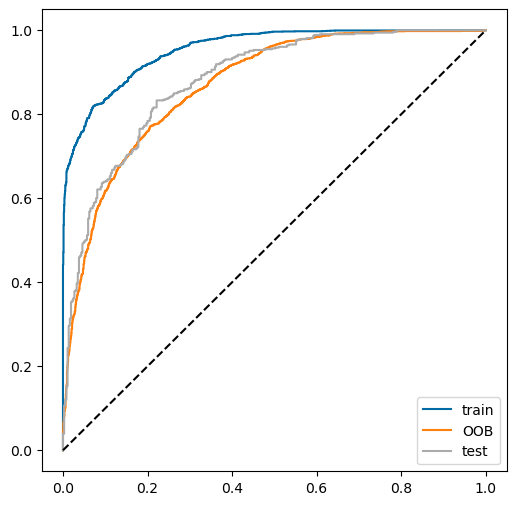

In [28]:
plt.figure(figsize=(6,6))
train_probs = cls.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, train_probs[:,1], pos_label=1)
plt.plot(fpr,tpr,label='train');

oob_probs = cls.oob_decision_function_
fpr, tpr, thresholds = metrics.roc_curve(y_train, oob_probs[:,1], pos_label=1)
plt.plot(fpr,tpr,label='OOB');

test_probs = cls.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_probs[:,1], pos_label=1)
plt.plot(fpr,tpr,label='test');

# random chance line
plt.plot((0,1),(0,1),'k--')
plt.legend();

Both our training/test split and model training involve random numbers, so we really should repeat them multiple times and collect statistics instead of just looking at a single value.

Let's get a sense of how much of a difference that makes.

Start with looking at the variability of the random forest results:

In [20]:
rf_accum = []
for i in range(10):
    cls = RandomForestClassifier(n_estimators=500,
                                 max_depth=15,
                                 oob_score=True,
                                 # diff random seeds
                                 random_state=0xf00d+i,
                                 n_jobs=4)
    cls.fit(X_train,y_train)
    preds = cls.predict(X_test)
    probs = cls.predict_proba(X_test)
    rf_accum.append(evaluate_model_performance(preds,probs,y_test))

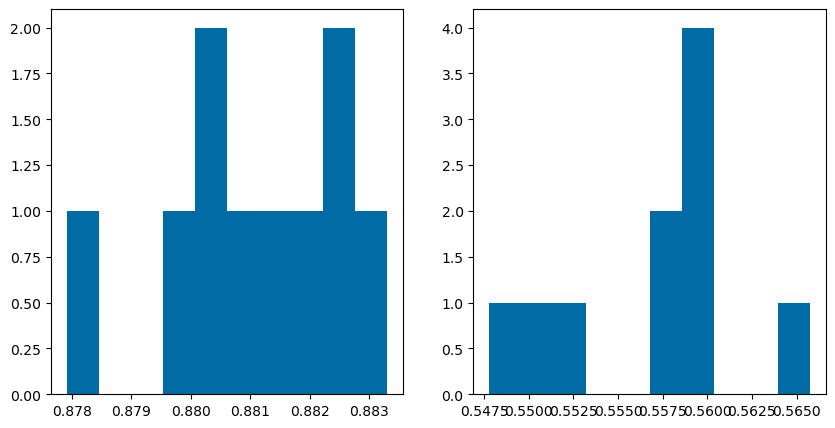

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist([x['auroc'] for x in rf_accum]);
plt.subplot(1,2,2)
plt.hist([x['mcc'] for x in rf_accum]);
# mathews correlation coeff

Calc median and median abs dev, instead of mean and std dev, because not gaussian distribs. 

In [22]:
for metric in ('accuracy','kappa','mcc','auroc'):
    print(f'{metric}: {np.median([x[metric] for x in rf_accum]):.3f} +/- {stats.median_abs_deviation([x[metric] for x in rf_accum]):.3f}')

accuracy: 0.783 +/- 0.001
kappa: 0.522 +/- 0.002
mcc: 0.558 +/- 0.001
auroc: 0.881 +/- 0.001


That's not a lot of variability. How much of a difference does the data split make?

In [23]:
split_accum = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(fps,
                                                        acts,
                                                        test_size=0.2,
                                                        random_state=0xf00d+i,
                                                        shuffle=True,
                                                        stratify=acts)
    cls = RandomForestClassifier(n_estimators=500,
                                 max_depth=15,
                                 oob_score=True,
                                 random_state=0xf00d+i,
                                 n_jobs=4)
    cls.fit(X_train,y_train)
    preds = cls.predict(X_test)
    probs = cls.predict_proba(X_test)
    split_accum.append(evaluate_model_performance(preds,probs,y_test))

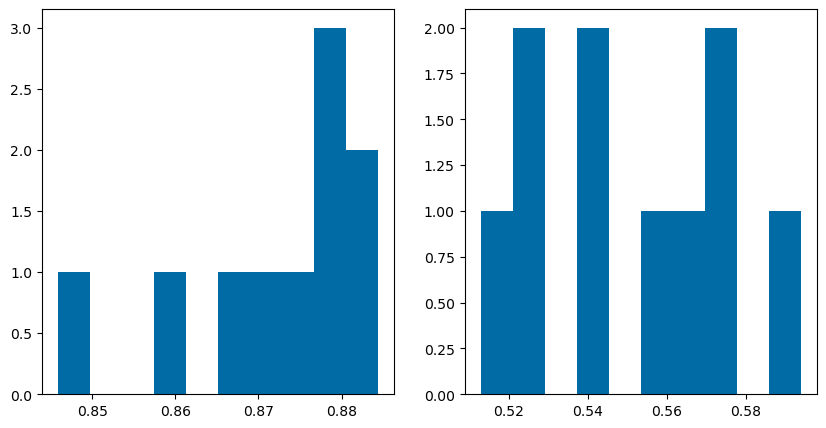

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist([x['auroc'] for x in split_accum]);
plt.subplot(1,2,2)
plt.hist([x['mcc'] for x in split_accum]);

In [25]:
for metric in ('accuracy','kappa','mcc','auroc'):
    print(f'{metric}: {np.median([x[metric] for x in split_accum]):.3f} +/- {stats.median_abs_deviation([x[metric] for x in split_accum]):.3f}')

accuracy: 0.780 +/- 0.009
kappa: 0.519 +/- 0.018
mcc: 0.548 +/- 0.023
auroc: 0.876 +/- 0.005


That's about an order of magnitude more variation, but it's still not horrible in this case.  Bc 1000's of data points, split doesn't make a diff usually, only big diff if smaller data set.

### I *always* check the variability with the data split and often check it with the random forest split as well.

# Exercise

cyps is measure of drug drug interactions, important for drug disco

In [30]:
df = pd.read_csv('./data/chembl_cyps.tsv.gz',sep='\t')
df.head()

,assay_id,doc_id,description,assay_organism,assay_chembl_id,pref_name,activity_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,pchembl_value,standard_inchi_key,canonical_smiles,compound_chembl_id,Iteration
0,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986597,778799,=,7943.28,nM,1,AC50,5.10,RJXCYVJLXGRCHK-UHFFFAOYSA-N,Fc1cccc(c1)C(=O)N2CCC3(CCN(Cc4ccccc4)CC3)CC2,CHEMBL1354915,0
1,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986598,878902,=,10000.00,nM,1,AC50,5.00,CFLWEGVGTKRSKY-UHFFFAOYSA-N,CN(C)C(=O)c1ccc(cc1)c2ccc3ncnc(Nc4ccc(F)cc4)c3c2,CHEMBL1455018,0
2,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986599,766975,=,22387.21,nM,1,AC50,4.65,BLYSRVMJHGAIMN-UHFFFAOYSA-N,CCCCn1nc2cc(ccc2c1OCC)C(=O)NC3CCCc4ccccc34,CHEMBL1343091,0
3,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986600,882987,=,15848.93,nM,1,AC50,4.80,RGBSTAYYVOCRDD-UHFFFAOYSA-N,CCOc1c2ccc(cc2nn1CCOC)C(=O)NCc3ccc4OCOc4c3,CHEMBL1459103,0
4,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986601,761292,=,2238.72,nM,1,AC50,5.65,WEANVNPBBLEIIO-UHFFFAOYSA-N,COc1ccc(NC(=O)CSc2nc(C)c3CCCCc3c2C#N)cc1,CHEMBL1337408,0


In [34]:
df_2d6 = df[df.assay_chembl_id=='CHEMBL1741321']
len(df_2d6)

# many dupe rows or dupe assays with diff cmpds

5680

In [33]:
PandasTools.AddMoleculeColumnToFrame(df_2d6,'canonical_smiles')

/Users/dimei.wu/mambaforge/envs/py310_aisem2023/lib/python3.10/site-packages/rdkit/Chem/PandasTools.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


See that warning? Do **not** ignore it.
The right thing to do is this:

In [37]:
# in prior, the df_2d6 is set to a view of df and it changes the df. so do copy of the view so gets new df!
# new df of rows matching chembl_id of 2d6 assay
df_2d6 = df[df.assay_chembl_id=='CHEMBL1741321'].copy()
PandasTools.AddMoleculeColumnToFrame(df_2d6,'canonical_smiles')
len(df_2d6)

5680

,assay_id,doc_id,description,assay_organism,assay_chembl_id,pref_name,activity_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,pchembl_value,standard_inchi_key,canonical_smiles,compound_chembl_id,Iteration,ROMol
0,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986597,778799,=,7943.28,nM,1,AC50,5.10,RJXCYVJLXGRCHK-UHFFFAOYSA-N,Fc1cccc(c1)C(=O)N2CCC3(CCN(Cc4ccccc4)CC3)CC2,CHEMBL1354915,0,
1,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986598,878902,=,10000.00,nM,1,AC50,5.00,CFLWEGVGTKRSKY-UHFFFAOYSA-N,CN(C)C(=O)c1ccc(cc1)c2ccc3ncnc(Nc4ccc(F)cc4)c3c2,CHEMBL1455018,0,
2,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986599,766975,=,22387.21,nM,1,AC50,4.65,BLYSRVMJHGAIMN-UHFFFAOYSA-N,CCCCn1nc2cc(ccc2c1OCC)C(=O)NC3CCCc4ccccc34,CHEMBL1343091,0,
3,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986600,882987,=,15848.93,nM,1,AC50,4.80,RGBSTAYYVOCRDD-UHFFFAOYSA-N,CCOc1c2ccc(cc2nn1CCOC)C(=O)NCc3ccc4OCOc4c3,CHEMBL1459103,0,
4,737822,51887,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,NaN,CHEMBL1741321,Cytochrome P450 2D6,5986601,761292,=,2238.72,nM,1,AC50,5.65,WEANVNPBBLEIIO-UHFFFAOYSA-N,COc1ccc(NC(=O)CSc2nc(C)c3CCCCc3c2C#N)cc1,CHEMBL1337408,0,

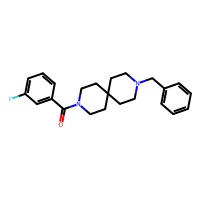
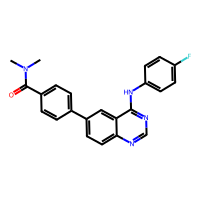
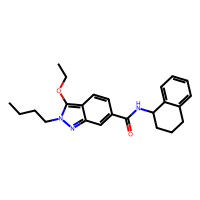
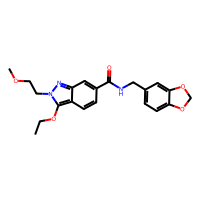
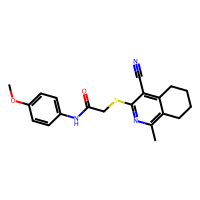

In [38]:
PandasTools.RenderImagesInAllDataFrames(True)
df_2d6.head()

In [39]:
df_2d6['mol_parent'] = df_2d6.ROMol.map(rdMolStandardize.ChargeParent)

In [65]:
# try 2. logistic regression from logP

df_2d6["logP"]=df_2d6.ROMol.map(lambda x: rdkit.Chem.Crippen.MolLogP( x) )
min(df_2d6["logP"]), max(df_2d6["logP"])

(-3.8552999999999935, 12.995199999999977)

In [104]:
import rdkit.Chem.rdFreeSASA
rdkit.Chem.rdFreeSASA.SASAClass.APolar(df_2d6.ROMol[0])

TypeError: 'SASAClass' object is not callable

fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
fps = [fpg.GetFingerprintAsNumPy(m) for m in df_2d6.mol_parent]

What are we going to use for an activity bin?

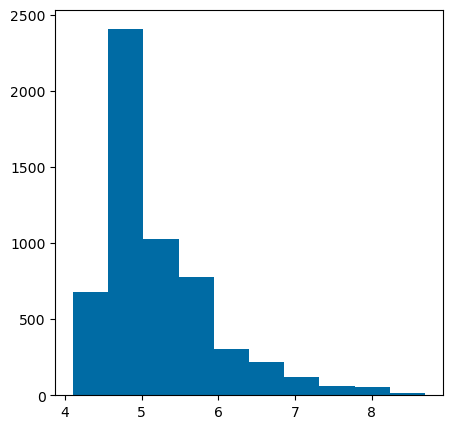

In [41]:
plt.figure(figsize=(5,5))
plt.hist(df_2d6.pchembl_value);

Let's try pchembl_value=6 = 1 uM


In [42]:
acts = [1 if x>=6 else 0 for x in df_2d6.pchembl_value]
len(acts),sum(acts)

(5680, 748)

This dataset is imbalanced!

Let's try one model and see what we get:

In [112]:
logP_array=df_2d6["logP"].to_numpy().reshape(-1,1)
fps_logP_array=[(fps[x], logP_array[x]) for x in range(0,df_2d6["logP"].shape[0])]
fps_logP_array

[(array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
         0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
         0, 0, 0, 1, 0, 0

In [101]:
fp=300
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=fp)
fps = [fpg.GetFingerprintAsNumPy(m) for m in df_2d6.mol_parent]

methlist=[df_2d6["logP"].to_numpy().reshape(-1,1)]

for i in range(0,len(methlist)):
    # try 3. loop log P, others
    X_train, X_test, y_train, y_test = train_test_split(methlist[i],
                                                        acts,
                                                        test_size=0.2,
                                                        random_state=0xf00d,
                                                        shuffle=True,
                                                        stratify=acts)
    cls = RandomForestClassifier(n_estimators=500,
                                 max_depth=15,
                                 oob_score=True,
                                 random_state=0xf00d,
                                 n_jobs=4)
    cls.fit(X_train,y_train)
    test_preds = cls.predict(X_test)
    test_probs = cls.predict_proba(X_test)
    
    show_model_performance(test_preds,test_probs,y_test)

# just logP replacing morgan fps went from 0.053 kappa to 0.064


Accuracy: 0.860 Kappa: 0.064 MCC: 0.093 AUROC: 0.524
Confusion matrix:
[[968  18]
 [141   9]]
Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       986
           1       0.33      0.06      0.10       150

    accuracy                           0.86      1136
   macro avg       0.60      0.52      0.51      1136
weighted avg       0.80      0.86      0.82      1136




In [97]:
# try 2. log P
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=fp)
fps = [fpg.GetFingerprintAsNumPy(m) for m in df_2d6.mol_parent]

X_train, X_test, y_train, y_test = train_test_split(fps_logP_array,
                                                    acts,
                                                    test_size=0.2,
                                                    random_state=0xf00d,
                                                    shuffle=True,
                                                    stratify=acts)
cls = RandomForestClassifier(n_estimators=500,
                             max_depth=15,
                             oob_score=True,
                             random_state=0xf00d,
                             n_jobs=4)
cls.fit(X_train,y_train)
test_preds = cls.predict(X_test)
test_probs = cls.predict_proba(X_test)
show_model_performance(test_preds,test_probs,y_test)

# just logP replacing morgan fps went from 0.053 kappa to 0.064

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (4544, 2) + inhomogeneous part.

In [66]:
# try 1. loop through diff fpSize. 300 to 3000, 300 was best.
# conclude 1. fpSize = 300 or lower. loop again
for fp in range (10, 300, 10):
    fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=fp)
    fps = [fpg.GetFingerprintAsNumPy(m) for m in df_2d6.mol_parent]

    X_train, X_test, y_train, y_test = train_test_split(fps,
                                                        acts,
                                                        test_size=0.2,
                                                        random_state=0xf00d,
                                                        shuffle=True,
                                                        stratify=acts)
    cls = RandomForestClassifier(n_estimators=500,
                                 max_depth=15,
                                 oob_score=True,
                                 random_state=0xf00d,
                                 n_jobs=4)
    cls.fit(X_train,y_train)
    test_preds = cls.predict(X_test)
    test_probs = cls.predict_proba(X_test)
    show_model_performance(test_preds,test_probs,y_test)



/Users/dimei.wu/mambaforge/envs/py310_aisem2023/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dimei.wu/mambaforge/envs/py310_aisem2023/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dimei.wu/mambaforge/envs/py310_aisem2023/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_


Accuracy: 0.868 Kappa: 0.000 MCC: 0.000 AUROC: 0.521
Confusion matrix:
[[986   0]
 [150   0]]
Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       986
           1       0.00      0.00      0.00       150

    accuracy                           0.87      1136
   macro avg       0.43      0.50      0.46      1136
weighted avg       0.75      0.87      0.81      1136



Accuracy: 0.863 Kappa: 0.018 MCC: 0.036 AUROC: 0.546
Confusion matrix:
[[977   9]
 [147   3]]
Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       986
           1       0.25      0.02      0.04       150

    accuracy                           0.86      1136
   macro avg       0.56      0.51      0.48      1136
weighted avg       0.79      0.86      0.81      1136



Accuracy: 0.870 Kappa: 0.101 MCC: 0.165 AUROC: 0.677
Confusion matrix:
[[977   9]
 [139  11]]
Report:
              precision    recall  

In [ ]:
# try grid search
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
>>> svc = svm.SVC()
>>> clf = GridSearchCV(svc, parameters)
>>> clf.fit(iris.data, iris.target)

So model rarely predicts positive actives, so low kappa.

Thus in binary classification, the count of true negatives is
:math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
:math:`C_{1,1}` and false positives is :math:`C_{0,1}`.


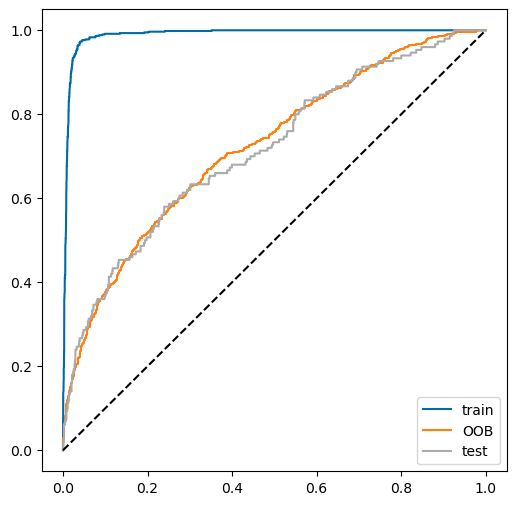

In [46]:
plt.figure(figsize=(6,6))
train_probs = cls.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, train_probs[:,1], pos_label=1)
plt.plot(fpr,tpr,label='train');

oob_probs = cls.oob_decision_function_
fpr, tpr, thresholds = metrics.roc_curve(y_train, oob_probs[:,1], pos_label=1)
plt.plot(fpr,tpr,label='OOB');

test_probs = cls.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_probs[:,1], pos_label=1)
plt.plot(fpr,tpr,label='test');

plt.plot((0,1),(0,1),'k--')
plt.legend();

Digression to talk about the impact of imbalance on machine learning performance

Could change threshold of classifying in/active to try to predict positive active more. Do later.

Variability:

In [109]:
split_accum = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(logP_array,
                                                        acts,
                                                        test_size=0.2,
                                                        random_state=0xf00d+i,
                                                        shuffle=True,
                                                        stratify=acts)
    cls = RandomForestClassifier(n_estimators=500,
                                 max_depth=15,
                                 oob_score=True,
                                 random_state=0xf00d+i,
                                 n_jobs=4)
    cls.fit(X_train,y_train)
    preds = cls.predict(X_test)
    probs = cls.predict_proba(X_test)
    split_accum.append(evaluate_model_performance(preds,probs,y_test))

for metric in ('accuracy','kappa','mcc','auroc'):
    print(f'{metric}: {np.median([x[metric] for x in split_accum]):.3f} +/- {stats.median_abs_deviation([x[metric] for x in split_accum]):.3f}')

accuracy: 0.858 +/- 0.002
kappa: 0.021 +/- 0.007
mcc: 0.034 +/- 0.011
auroc: 0.525 +/- 0.009


Not a lot of variability. That's good!

In [ ]:
# 3. to do: concat arrays together 
# e.g. logP and 3d struc data to get more chem features as input for random forest
# recall: need multiple features for random forest to make good decisions

In [106]:
from xgboost import XGBClassifier
# note max_depth lower 3 vs 15
# default XGBoost doesn't use stochastic g boost with randomness, instead deterministic 
cls = XGBClassifier(max_depth=3,
                         n_estimators=300,
                         random_state=0xf00d,
                         n_jobs=4)
cls.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=4, num_parallel_tree=None,
              predictor=None, random_state=61453, ...)

Better pred accuracy, see better kappa, bc got 17% of actives w 50% pred accuracy whereas before was like 3

In [107]:
preds = cls.predict(X_test)
probs = cls.predict_proba(X_test)
show_model_performance(preds,probs,y_test)


Accuracy: 0.864 Kappa: 0.012 MCC: 0.029 AUROC: 0.568
Confusion matrix:
[[980   6]
 [148   2]]
Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       986
           1       0.25      0.01      0.03       150

    accuracy                           0.86      1136
   macro avg       0.56      0.50      0.48      1136
weighted avg       0.79      0.86      0.81      1136




In [108]:
split_accum = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(logP_array,
                                                        acts,
                                                        test_size=0.2,
                                                        random_state=0xf00d+i,
                                                        shuffle=True,
                                                        stratify=acts)
    cls = XGBClassifier(max_depth=3,
                         n_estimators=300,
                         random_state=0xf00d+i,
                         n_jobs=4)
    cls.fit(X_train,y_train)
    preds = cls.predict(X_test)
    probs = cls.predict_proba(X_test)
    split_accum.append(evaluate_model_performance(preds,probs,y_test))

for metric in ('accuracy','kappa','mcc','auroc'):
    print(f'{metric}: {np.median([x[metric] for x in split_accum]):.3f} +/- {stats.median_abs_deviation([x[metric] for x in split_accum]):.3f}')

accuracy: 0.862 +/- 0.002
kappa: 0.010 +/- 0.010
mcc: 0.024 +/- 0.021
auroc: 0.533 +/- 0.014


## Additional tasks to try

Some things you might try:

1. Try other model hyperparemters: number of trees, tree depth, etc (look at the scikit-learn docs for more) and see if those make a difference.
1. Try other fingerprints (RDKit FP, lower or shorter bits, topological torsion, atom pair, look at atom counts, fingerprint lengths, etc.) and see if they make a difference. Here's a tutorial for the fingerprint generator: https://greglandrum.github.io/rdkit-blog/posts/2023-01-18-fingerprint-generator-tutorial.html
2. Try one or more of the other assays (CYP targets) in the input file. Do you see differences in predictive performance?
3. Try finding the set of compounds which have been tested against all of the CYPs (we did something like this yesterday) and build a model to predict whether or not a particular compound is selective for a particular CYP (i.e. is active against that CYP but not any of the others).
4. Try using logistic regression as the model type and see how it performs relative to random forests and XGB?
5. Try using a vector of descriptors instead of a fingerprint. How well does that perform? Here's a tutorial for descriptor calculation: https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html
6. Look in the online version of ChEMBL and see if you can find additional compounds for CYP 2D6. See how well the models built above perform on those external validation compounds. **Note** that we have to be quite careful here because comparing IC50/AC50/EC50/etc values between different assays is generally unreliable


# Very, very, very important note

In this exercise we have not actually done real validation of our model: we've used the whole dataset as we've tried different algorithms, fingerprints, hyperparameters, etc.

If you want to know if the model actually works, you need to try it on a set of data that it hasn't seen before in any way.

### Let's try:

feature optimization 

In [53]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
# try change linear to rbf or poly to see effect of C on kernel trick SVMs
